<div style="text-align: center;">
  <h2><u><strong>Deep Learning 2025 - Project Assignment</strong></u></h2>
  <p>
    Elia Avanzolini<br>
    Matricola: 256153
  </p>
  <p>
    Martina Panini<br>
    Matricola: 257851
  </p>
  <p>
    Jie Chen<br>
    Matricola: 256177
  </p>
</div>

## Abstract
This project addresses the challenge of few-shot adaptation in vision-language models, focusing on improving CLIP's performance on base classes while preserving its zero-shot generalization to novel categories. We propose a hybrid approach combining LoRA-based vision encoder adaptation with Tip-Adapter-F, a cache-based approach that stores features from the few-shot examples to enhance base-class predictions. An adaptive ensemble integrates predictions from the specialized LoRA-finetuned model and the original pre-trained model, dynamically balancing confidence between base and novel categories. Evaluated on the Oxford Flowers-102 dataset, our method demonstrates that LoRA specialization boosts base-class accuracy but reduces novel-class performance, while Tip-Adapter-F maintains transferability. The ensemble strategy effectively balances these trade-offs, achieving a 24.67% improvement in base-class accuracy (from 71.33% to 96.00%) and preserving novel-class accuracy (77.64%), yielding the highest harmonic mean (85.85%). Our results highlight the importance of integrating parameter-efficient adaptation with memory-based methods for robust few-shot learning in vision-language systems.

## Introduction

Large-scale vision-language models such as CLIP have demonstrated remarkable generalization capabilities in zero-shot image classification by leveraging contrastive learning on massive image-text pairs. However, their performance tends to decline in fine-grained tasks and few-shot scenarios, particularly when strong accuracy on base classes is required without degrading generalization to novel ones.

In this project, we tackle the **Few-Shot Adaptation** problem as define in project assignment. Specifically, we aim to improve classification accuracy on base categories from the Oxford Flowers-102 dataset using only the 10 labeled examples provided per class, while trying to preserve the model’s original zero-shot performance on novel categories. Therefore, our aim is to develop a final model that balance high accuracy on base classes and maintain strong generalization to novel classes, measured via their **harmonic mean**.

To address this challenge, we propose a method that combines three complementary components:

- **LoRA-based adaptation of the CLIP vision encoder**, enabling efficient and targeted updates to class-level vision embeddings while keeping the rest of the model frozen.
- **Tip-Adapter-F**, a parameter-efficient fine-tuning approach that trains a lightweight MLP adapter on top of frozen CLIP image features to better align support image embeddings with their corresponding class prototypes.
- **Ensemble scoring**, where we combine predictions from previous methods, yielding a final score that benefits from both. 

We evaluate our approach using three key metrics:
1. CLIP zero-shot accuracy on **base classes**,
2. CLIP zero-shot accuracy on **novel classes**, and
3. The **harmonic mean** of the two, which reflects the trade-off between specialization and generalization.

These metrics form our baseline for comparison. The central objective of our work is to **maximize base class accuracy using only the provided few-shot data**, while **minimizing any drop in performance on the novel classes**.

In [13]:
# we need to install clip as it is not pre-installed
# https://github.com/mlfoundations/open_clip
%pip install openai_clip


Note: you may need to restart the kernel to use updated packages.


In [14]:
#Here we import the necessary libraries

import clip

import math
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from typing import Optional, List, Tuple, Union, Callable, Dict
from PIL import Image
from collections import OrderedDict

import torch
import torch.optim as optim
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.init import xavier_uniform_
from torch.nn.init import constant_
from torch.nn.init import xavier_normal_

import warnings



In [15]:
# Set up the device (GPU if available, otherwise CPU)
if torch.cuda.is_available():
    device = "cuda"
    torch.cuda.empty_cache()
else:
    device = "cpu"
print(f"Using device: {device}")

Using device: cuda


## Methodology

We conduct our experiments on the **Oxford Flowers-102** dataset [1], a widely used benchmark for fine-grained image classification. The dataset contains 102 flower categories, selected from species commonly found in the United Kingdom. Each class includes between 40 and 258 images, with substantial variation in scale, pose, and lighting conditions. Additionally, several categories exhibit high intra-class variation and inter-class similarity, making the classification task particularly challenging.

For this project, we use the official split and helper code provided with the assignment to download, load, and partition the dataset. As the training set contains exactly 10 labeled images per class, we adopt a **10-shot** setting (i.e., *k = 10*) for all our few-shot learning experiments.


In [16]:
# Define list of class names
CLASS_NAMES = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea", "english marigold", "tiger lily", "moon orchid", "bird of paradise", "monkshood", "globe thistle", "snapdragon", "colt's foot", "king protea", "spear thistle", "yellow iris", "globe-flower", "purple coneflower", "peruvian lily", "balloon flower", "giant white arum lily", "fire lily", "pincushion flower", "fritillary", "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers", "stemless gentian", "artichoke", "sweet william", "carnation", "garden phlox", "love in the mist", "mexican aster", "alpine sea holly", "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip", "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia", "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy", "common dandelion", "petunia", "wild pansy", "primula", "sunflower", "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia", "pink-yellow dahlia?", "cautleya spicata", "japanese anemone", "black-eyed susan", "silverbush", "californian poppy", "osteospermum", "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania", "azalea", "water lily", "rose", "thorn apple", "morning glory", "passion flower", "lotus", "toad lily", "anthurium", "frangipani", "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow", "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum", "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow", "mexican petunia", "bromelia", "blanket flower", "trumpet creeper", "blackberry lily"]

In [17]:
# Same function provided in the class notebook 
def get_data(data_dir="./data", transform=None):
    """Loads Flowers102 train, validation, and test sets."""
    train = torchvision.datasets.Flowers102(root=data_dir, split="train", download=True, transform=transform)
    val = torchvision.datasets.Flowers102(root=data_dir, split="val", download=True, transform=transform)
    test = torchvision.datasets.Flowers102(root=data_dir, split="test", download=True, transform=transform)
    return train, val, test

def base_novel_categories(dataset):
    """Splits dataset categories into base and novel classes."""
    all_classes = set(dataset._labels)
    num_classes = len(all_classes)
    base_classes = list(range(num_classes))[:num_classes//2]
    novel_classes = list(range(num_classes))[num_classes//2:]
    return base_classes, novel_classes

def split_data(dataset, base_classes):
    """Divides a dataset into subsets based on base and novel categories."""
    base_categories_samples = []
    novel_categories_samples = []
    base_set = set(base_classes)
    for sample_id, label in enumerate(dataset._labels):
        if label in base_set:
            base_categories_samples.append(sample_id)
        else:
            novel_categories_samples.append(sample_id)
    base_dataset = torch.utils.data.Subset(dataset, base_categories_samples)
    novel_dataset = torch.utils.data.Subset(dataset, novel_categories_samples)
    return base_dataset, novel_dataset

def harmonic_mean(base_accuracy, novel_accuracy):
    """Calculates the harmonic mean of two accuracies."""
    numerator = 2
    denominator = 1 / base_accuracy + 1 / novel_accuracy
    return numerator / denominator

# Evaluation function from the provided notebook
@torch.no_grad()
def eval_zeroshot(model, dataset, categories, batch_size, device, label=""):
    model.eval()
    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}
    text_inputs = clip.tokenize(
        [f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in categories]
    ).to(device)
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    correct_predictions = 0
    for image, target in tqdm(dataloader, desc=label):
        target = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long()
        image = image.to(device)
        target = target.to(device)
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        predicted_class = (image_features @ text_features.T).argmax(dim=-1)
        correct_predictions += (predicted_class == target).sum().item()
    accuracy = correct_predictions / len(dataset)
    return accuracy

### Compute Baseline


We begin our experiments by evaluating the zero-shot performance of the original CLIP model on both the base and novel classes of the Oxford Flowers-102 dataset. Specifically, we compute the top-1 classification accuracy separately for base and novel categories. From these two metrics, we also derive their **harmonic mean**, which provides a balanced measure of performance across both domains.

These three values — base accuracy, novel accuracy, and their harmonic mean — serve as our **baseline** for all subsequent comparisons. They allow us to quantify the impact of each adaptation method not only on the accuracy of base classes (where fine-tuning occurs), but also on the model's ability to retain generalization to unseen (novel) classes.


In [18]:
print("Zero-Shot CLIP Baseline")
print("Loading original CLIP model and preparing dataset...")

# Load the original CLIP model and its pre-processing function
clip_model, clip_preprocess = clip.load("ViT-B/16", device=device)

# Get the Flowers102 datasets
train_set, val_set, test_set = get_data(transform=clip_preprocess)

# Split classes and datasets into base and novel categories
base_classes, novel_classes = base_novel_categories(train_set)
train_base, _ = split_data(train_set, base_classes)
val_base, _ = split_data(val_set, base_classes)
test_base, test_novel = split_data(test_set, base_classes)


base_accuracy = eval_zeroshot(model=clip_model, dataset=test_base, categories=base_classes, batch_size=128, device=device, label="🧠 Zero-shot evaluation on Base Classes")
novel_accuracy = eval_zeroshot(model=clip_model, dataset=test_novel, categories=novel_classes, batch_size=128, device=device, label="🧠 Zero-shot evaluation on Novel Classes")

print("Dataset prepared.")
print(f"Number of base training samples: {len(train_base)}")
print(f"Number of novel test samples: {len(test_novel)}")
print(f"Base classes accuracy: {base_accuracy*100:.2f}%")
print(f"Novel classes accuracy: {novel_accuracy*100:.2f}%")
print(f"Harmonic Mean: {harmonic_mean(base_accuracy, novel_accuracy)*100:.2f}%")

# Store baseline scores for plotting
base_accuracy_zeroshot = base_accuracy
novel_accuracy_zeroshot = novel_accuracy
hm_zeroshot = harmonic_mean(base_accuracy_zeroshot, novel_accuracy_zeroshot)

Zero-Shot CLIP Baseline
Loading original CLIP model and preparing dataset...


🧠 Zero-shot evaluation on Novel Classes: 100%|██████████| 29/29 [00:16<00:00,  1.81it/s]

Dataset prepared.
Number of base training samples: 510
Number of novel test samples: 3676
Base classes accuracy: 71.33%
Novel classes accuracy: 78.24%
Harmonic Mean: 74.62%


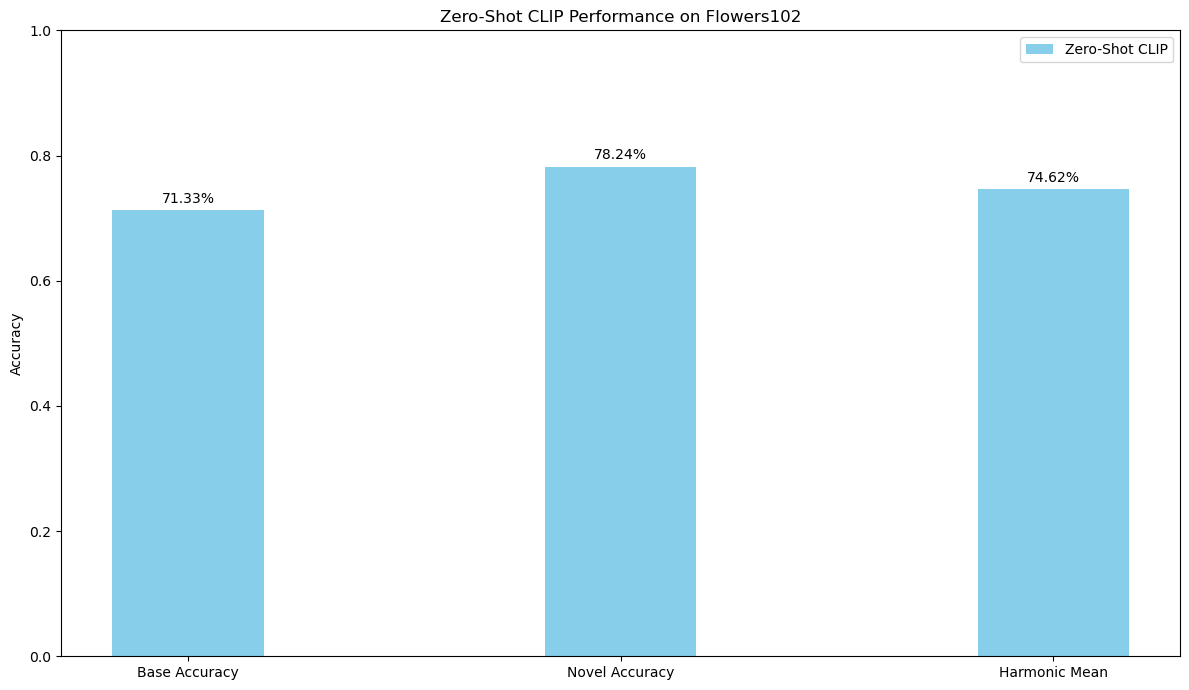

In [19]:
# Plot Zero-Shot Baseline
labels = ['Base Accuracy', 'Novel Accuracy', 'Harmonic Mean']
zeroshot_scores = [base_accuracy_zeroshot, novel_accuracy_zeroshot, hm_zeroshot]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 7))
rects = ax.bar(x, zeroshot_scores, width, label='Zero-Shot CLIP', color='skyblue')

ax.set_ylabel('Accuracy')
ax.set_title('Zero-Shot CLIP Performance on Flowers102')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.0)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height*100:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)
fig.tight_layout()
plt.show()

### LoRA

**Low-Rank Adaptation (LoRA)** is a parameter-efficient fine-tuning method that constrains weight updates during adaptation to a low-rank subspace. It was introduced to address the high memory and computational cost of updating all parameters in large-scale pre-trained models such as CLIP.

### Theoretical Motivation

Pre-trained deep networks, including transformer-based vision-language models, have weight matrices that are generally **full rank**. However, prior work (Aghajanyan et al., 2020) shows that such models often have a **low intrinsic dimension**, meaning that their learned representations and the space of useful adaptations occupy a much smaller subspace than the total parameter space.  

This implies that during fine-tuning, the effective change in weights can be approximated by a low-rank update without significantly limiting the model’s ability to learn the new task. Instead of updating a large $d \times k$ weight matrix directly, LoRA re-parameterizes the update as the product of two much smaller matrices:  

$$
W = W_0 + \Delta W, \quad \Delta W = BA
$$

Here, $W_0 \in \mathbb{R}^{d \times k}$ is the pre-trained weight matrix (frozen during adaptation), $B \in \mathbb{R}^{d \times r}$ and $A \in \mathbb{R}^{r \times k}$ are trainable matrices, and $r \ll \min(d, k)$ is the rank of the update. The rank $r$ controls the adaptation capacity: a small $r$ limits the expressiveness of the update but keeps parameter count low, while a larger $r$ allows more flexibility at the cost of increased parameters.

In standard matrix multiplication, the output is:

$$
h = W_0 x
$$

With LoRA, the forward pass becomes:

$$
h = W_0 x + \gamma \cdot (B A x)
$$

where $\gamma$ is a scaling factor applied to the low-rank update to stabilize training. $A$ is initialized, and $B$ is set to all zeros, ensuring $\Delta W = 0$ at the start, so the initial output is identical to the pre-trained model. This initialization makes LoRA particularly stable in few-shot learning: at the beginning of training, the model performs identically to the base model, and adaptation happens gradually as $A$ and $B$ learn.

For a typical CLIP transformer layer, the number of additional parameters introduced by LoRA with rank r, is:

$$
\text{Params} = r \cdot (d + k)
$$

This is a small fraction of the full $d \times k$ parameters. By freezing $W_0$, memory usage is reduced since no gradient storage is needed for frozen weights, overfitting risk is lowered in few-shot scenarios, and training is speed up while preserving most pre-trained knowledge.


### Application to CLIP

CLIP consists of a vision encoder and a text encoder, both implemented as transformer stacks with multi-head attention (MHA) modules. Each MHA block contains **query**, **key**, and **value** projection matrices, which are prime candidates for LoRA insertion. In our setup, LoRA is applied only to the vision encoder, while the text encoder remains frozen. 


### Implementation Details

The Loraload function loads the original CLIP model, inserts LoRA modules into the vision encoder, marks only LoRA parameters along with positional_embedding and logit_scale as trainable, and keeps all other parameters frozen to maintain parameter efficiency.

### Fine-Tuning Procedure

The fine-tuning begins by reloading the CLIP ViT-B/16 model from scratch for a clean start, followed by LoRA injection into the vision encoder with rank $r = 8$. The training loop uses AdamW with a learning rate of $5 e^{-4}$ and cross-entropy loss for 15 epochs. For each batch, class names are tokenized into the format "a photo of a {class_name}, a type of flower.", images are encoded using the LoRA-adapted vision encoder, and text is encoded using the frozen text encoder. Features are normalized, cosine similarity logits are computed, targets are mapped to base-class indices, and loss is computed to update only LoRA parameters.



### Why Only Vision-Encoder?

We choose to apply LoRA only to the vision encoder because it provides the best trade-off between adaptation effectiveness and preserving CLIP’s strong zero-shot capabilities. The vision encoder extracts visual representations from images, so fine-tuning it allows the model to better capture task-specific visual patterns and adapt to the characteristics of the new dataset. Meanwhile, freezing the text encoder preserves the alignment between natural language prompts and class names, ensuring the model retains its robust zero-shot interpretability. This approach is also more parameter-efficient and computationally lighter compared to tuning both encoders, making training faster and more stable. Empirically, adapting just the vision encoder yields better results than tuning the text encoder or both encoders, improving base-class accuracy without sacrificing generalization to unseen categories.

In order to write this section we took inspirtation from various resources:
 - Microsoft LoRA (https://github.com/microsoft/LoRA)
 - Lora-Clip Easy Wrapper (https://github.com/jaisidhsingh/LoRA-CLIP/tree/main?tab=readme-ov-file)
 - Clip-Lora (https://github.com/MaxZanella/CLIP-LoRA/tree/main)

In [ ]:
# Here we define all the functions used to run LoRA
class LoRALayer():
    def __init__(
        self,
        r: int,
        lora_alpha: int,
        lora_dropout: float,
        merge_weights: bool,
    ):
        self.r = r
        self.lora_alpha = lora_alpha
        # Optional dropout
        if lora_dropout > 0.:
            self.lora_dropout = nn.Dropout(p=lora_dropout)
        else:
            self.lora_dropout = lambda x: x
        # Mark the weight as unmerged
        self.merged = False
        self.merge_weights = merge_weights


class Embedding(nn.Embedding, LoRALayer):
    # LoRA implemented in a dense layer
    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        r: int = 0,
        lora_alpha: int = 1,
        merge_weights: bool = True,
        **kwargs
    ):
        nn.Embedding.__init__(self, num_embeddings, embedding_dim, **kwargs)
        LoRALayer.__init__(self, r=r, lora_alpha=lora_alpha, lora_dropout=0,
                           merge_weights=merge_weights)
        # Actual trainable parameters 
        if r > 0:
            self.lora_A = nn.Parameter(self.weight.new_zeros((r, num_embeddings)))
            self.lora_B = nn.Parameter(self.weight.new_zeros((embedding_dim, r)))
            self.lora_gate = nn.Parameter(torch.tensor(0.0))
            self.scaling = self.lora_alpha / self.r
            # Freezing the pre-trained weight matrix
            self.weight.requires_grad = False
        self.reset_parameters()

    def reset_parameters(self):
        nn.Embedding.reset_parameters(self)
        if hasattr(self, 'lora_A'):
            # initialize A the same way as the default for nn.Linear and B to zero
            nn.init.zeros_(self.lora_A)
            nn.init.normal_(self.lora_B)

    def train(self, mode: bool = True):
        nn.Embedding.train(self, mode)
        if self.merge_weights and self.merged:
            # Make sure that the weights are not merged
            if self.r > 0:
                self.weight.data -= (self.lora_B @ self.lora_A).T * self.scaling
            self.merged = False

    def eval(self):
        nn.Linear.eval(self)
        if self.merge_weights and not self.merged:
            # Merge the weights and mark it
            if self.r > 0:
                self.weight.data += (self.lora_B @ self.lora_A) * self.scaling
            self.merged = True

    def forward(self, x: torch.Tensor):
        if self.r > 0 and not self.merged:
            result = nn.Embedding.forward(self, x)
            if self.r > 0:
                after_A = F.embedding(
                    x, self.lora_A.T, self.padding_idx, self.max_norm,
                    self.norm_type, self.scale_grad_by_freq, self.sparse
                )
                result += (after_A @ self.lora_B.T) * self.scaling
            return result
        else:
            return nn.Embedding.forward(self, x)


class Linear(nn.Linear, LoRALayer):
    # LoRA implemented in a dense layer
    def __init__(
        self,
        in_features: int,
        out_features: int,
        r: int = 0,
        lora_alpha: int = 1,
        lora_dropout: float = 0.,
        fan_in_fan_out: bool = False, # Set this to True if the layer to replace stores weight like (fan_in, fan_out)
        merge_weights: bool = True,
        **kwargs
    ):
        nn.Linear.__init__(self, in_features, out_features, **kwargs)
        LoRALayer.__init__(self, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout,
                           merge_weights=merge_weights)

        self.fan_in_fan_out = fan_in_fan_out
        # Actual trainable parameters
        if r > 0:
            self.lora_A = nn.Parameter(self.weight.new_zeros((r, in_features)))
            self.lora_B = nn.Parameter(self.weight.new_zeros((out_features, r)))
            self.lora_gate = nn.Parameter(torch.tensor(0.0)) 
            self.scaling = self.lora_alpha / self.r
            # Freezing the pre-trained weight matrix
            self.weight.requires_grad = False
        self.reset_parameters()
        if fan_in_fan_out:
            self.weight.data = self.weight.data.T

    def reset_parameters(self):
        nn.Linear.reset_parameters(self)
        if hasattr(self, 'lora_A'):
            # initialize A the same way as the default for nn.Linear and B to zero
            nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
            nn.init.zeros_(self.lora_B)

    def train(self, mode: bool = True):
        def T(w):
            return w.T if self.fan_in_fan_out else w
        nn.Linear.train(self, mode)
        if self.merge_weights and self.merged:
            # Make sure that the weights are not merged
            if self.r > 0:
                self.weight.data -= T(self.lora_B @ self.lora_A) * self.scaling
            self.merged = False

    def eval(self):
        def T(w):
            return w.T if self.fan_in_fan_out else w
        nn.Linear.eval(self)
        if self.merge_weights and not self.merged:
            # Merge the weights and mark it
            if self.r > 0:
                self.weight.data += T(self.lora_B @ self.lora_A) * self.scaling
            self.merged = True

    def forward(self, x: torch.Tensor):
        def T(w):
            return w.T if self.fan_in_fan_out else w
        if self.r > 0 and not self.merged:
            result = F.linear(x, T(self.weight), bias=self.bias)
            if self.r > 0:
                result += ((self.lora_dropout(x) @ self.lora_A.T @ self.lora_B.T) * torch.sigmoid(self.lora_gate)) * self.scaling 
            return result
        else:
            return F.linear(x, T(self.weight), bias=self.bias)


class MergedLinear(nn.Linear, LoRALayer):
    # LoRA implemented in a dense layer
    def __init__(
        self,
        in_features: int,
        out_features: int,
        r: int = 0,
        lora_alpha: int = 1,
        lora_dropout: float = 0.,
        enable_lora: List[bool] = [False],
        fan_in_fan_out: bool = False,
        merge_weights: bool = True,
        **kwargs
    ):
        nn.Linear.__init__(self, in_features, out_features, **kwargs)
        LoRALayer.__init__(self, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout,
                           merge_weights=merge_weights)
        assert out_features % len(enable_lora) == 0, \
            'The length of enable_lora must divide out_features'
        self.enable_lora = enable_lora
        self.fan_in_fan_out = fan_in_fan_out
        # Actual trainable parameters
        if r > 0 and any(enable_lora):
            self.lora_A = nn.Parameter(
                self.weight.new_zeros((r * sum(enable_lora), in_features)))
            self.lora_B = nn.Parameter(
                self.weight.new_zeros((out_features // len(enable_lora) * sum(enable_lora), r))
            ) # weights for Conv1D with groups=sum(enable_lora)
            self.lora_gate = nn.Parameter(torch.tensor(0.0))
            self.scaling = self.lora_alpha / self.r
            # Freezing the pre-trained weight matrix
            self.weight.requires_grad = False
            # Compute the indices
            self.lora_ind = self.weight.new_zeros(
                (out_features, ), dtype=torch.bool
            ).view(len(enable_lora), -1)
            self.lora_ind[enable_lora, :] = True
            self.lora_ind = self.lora_ind.view(-1)
        self.reset_parameters()
        if fan_in_fan_out:
            self.weight.data = self.weight.data.T

    def reset_parameters(self):
        nn.Linear.reset_parameters(self)
        if hasattr(self, 'lora_A'):
            # initialize A the same way as the default for nn.Linear and B to zero
            nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
            nn.init.zeros_(self.lora_B)

    def zero_pad(self, x):
        result = x.new_zeros((*x.shape[:-1], self.out_features))
        result = result.view(-1, self.out_features)
        result[:, self.lora_ind] = x.reshape(
            -1, self.out_features // len(self.enable_lora) * sum(self.enable_lora)
        )
        return result.view((*x.shape[:-1], self.out_features))

    def train(self, mode: bool = True):
        def T(w):
            return w.T if self.fan_in_fan_out else w
        nn.Linear.train(self, mode)
        if self.merge_weights and self.merged:
            # Make sure that the weights are not merged
            if self.r > 0 and any(self.enable_lora):
                delta_w = F.conv1d(
                    self.lora_A.data.unsqueeze(0),
                    self.lora_B.data.unsqueeze(-1),
                    groups=sum(self.enable_lora)
                ).squeeze(0)
                self.weight.data -= self.zero_pad(T(delta_w * self.scaling))
            self.merged = False

    def eval(self):
        def T(w):
            return w.T if self.fan_in_fan_out else w
        nn.Linear.eval(self)
        if self.merge_weights and not self.merged:
            # Merge the weights and mark it
            if self.r > 0 and any(self.enable_lora):
                delta_w = F.conv1d(
                    self.lora_A.data.unsqueeze(0),
                    self.lora_B.data.unsqueeze(-1),
                    groups=sum(self.enable_lora)
                ).squeeze(0)
                self.weight.data += self.zero_pad(T(delta_w * self.scaling))
            self.merged = True

    def forward(self, x: torch.Tensor):
        def T(w):
            return w.T if self.fan_in_fan_out else w
        if self.merged:
            return F.linear(x, T(self.weight), bias=self.bias)
        else:
            result = F.linear(x, T(self.weight), bias=self.bias)
            if self.r > 0:
                after_A = F.linear(self.lora_dropout(x), self.lora_A)
                after_B = F.conv1d(
                    after_A.transpose(-2, -1),
                    self.lora_B.unsqueeze(-1),
                    groups=sum(self.enable_lora)
                ).transpose(-2, -1)
                result += self.zero_pad(after_B) * self.scaling
            return result


class Conv2d(nn.Conv2d, LoRALayer):
    # LoRA implemented in a dense layer
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        r: int = 0,
        lora_alpha: int = 1,
        lora_dropout: float = 0.,
        merge_weights: bool = True,
        **kwargs
    ):
        nn.Conv2d.__init__(self, in_channels, out_channels, kernel_size, **kwargs)
        LoRALayer.__init__(self, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout,
                           merge_weights=merge_weights)
        assert type(kernel_size) is int
        # Actual trainable parameters
        if r > 0:
            self.lora_A = nn.Parameter(
                self.weight.new_zeros((r*kernel_size, in_channels*kernel_size))
            )
            self.lora_B = nn.Parameter(
                self.weight.new_zeros((out_channels*kernel_size, r*kernel_size))
            )
            self.lora_gate = nn.Parameter(torch.tensor(0.0))
            self.scaling = self.lora_alpha / self.r
            # Freezing the pre-trained weight matrix
            self.weight.requires_grad = False
        self.reset_parameters()

    def reset_parameters(self):
        nn.Conv2d.reset_parameters(self)
        if hasattr(self, 'lora_A'):
            # initialize A the same way as the default for nn.Linear and B to zero
            nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
            nn.init.zeros_(self.lora_B)

    def train(self, mode: bool = True):
        nn.Conv2d.train(self, mode)
        if self.merge_weights and self.merged:
            # Make sure that the weights are not merged
            self.weight.data -= (self.lora_B @ self.lora_A).view(self.weight.shape) * self.scaling
            self.merged = False

    def eval(self):
        nn.Conv2d.eval(self)
        if self.merge_weights and not self.merged:
            # Merge the weights and mark it
            self.weight.data += (self.lora_B @ self.lora_A).view(self.weight.shape) * self.scaling
            self.merged = True

    def forward(self, x: torch.Tensor):
        if self.r > 0 and not self.merged:
            return F.conv2d(
                x,
                self.weight + (self.lora_B @ self.lora_A).view(self.weight.shape) * self.scaling,
                self.bias, self.stride, self.padding, self.dilation, self.groups
            )
        return nn.Conv2d.forward(self, x)

class MultiheadAttention(nn.Module):
    r"""Allows the model to jointly attend to information
    from different representation subspaces.
    See reference: Attention Is All You Need
    .. math::
        \text{MultiHead}(Q, K, V) = \text{Concat}(head_1,\dots,head_h)W^O
        \text{where} head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
    Args:
        embed_dim: total dimension of the model.
        num_heads: parallel attention heads.
        dropout: a Dropout layer on attn_output_weights. Default: 0.0.
        bias: add bias as module parameter. Default: True.
        add_bias_kv: add bias to the key and value sequences at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        kdim: total number of features in key. Default: None.
        vdim: total number of features in value. Default: None.
        Note: if kdim and vdim are None, they will be set to embed_dim such that
        query, key, and value have the same number of features.
    Examples::
        >>> multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
        >>> attn_output, attn_output_weights = multihead_attn(query, key, value)
    """
    bias_k: Optional[torch.Tensor]
    bias_v: Optional[torch.Tensor]

    def __init__(self, embed_dim, num_heads, dropout=0., bias=True, add_bias_kv=False, add_zero_attn=False, kdim=None, vdim=None, lora_alpha: int = 1, r=0):
        super(MultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim

        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        assert r > 0

        self.lora_alpha = lora_alpha
        self.r = r
        self.scaling = self.lora_alpha / self.r

        if self._qkv_same_embed_dim is False:
            self.q_proj_weight = nn.Parameter(torch.Tensor(embed_dim, embed_dim))
            self.k_proj_weight = nn.Parameter(torch.Tensor(embed_dim, self.kdim))
            self.v_proj_weight = nn.Parameter(torch.Tensor(embed_dim, self.vdim))
            self.q_proj_weight_lora_A = nn.Parameter(torch.Tensor(r, embed_dim))
            self.k_proj_weight_lora_A = nn.Parameter(torch.Tensor(r, self.kdim))
            self.v_proj_weight_lora_A = nn.Parameter(torch.Tensor(r, self.vdim))
            self.q_proj_weight_lora_B = nn.Parameter(torch.Tensor(embed_dim, r))
            self.k_proj_weight_lora_B = nn.Parameter(torch.Tensor(embed_dim, r))
            self.v_proj_weight_lora_B = nn.Parameter(torch.Tensor(embed_dim, r))
            self.register_parameter('in_proj_weight', None)
            self.register_parameter('in_proj_weight_lora_A', None)
            self.register_parameter('in_proj_weight_lora_B', None)
        else:
            self.in_proj_weight = nn.Parameter(torch.empty(3 * embed_dim, embed_dim))
            self.in_proj_weight_lora_A = nn.Parameter(torch.empty(r, embed_dim))
            self.in_proj_weight_lora_B = nn.Parameter(torch.empty(3 * embed_dim, r))
            self.register_parameter('q_proj_weight', None)
            self.register_parameter('k_proj_weight', None)
            self.register_parameter('v_proj_weight', None)
            self.register_parameter('q_proj_weight_lora_A', None)
            self.register_parameter('k_proj_weight_lora_A', None)
            self.register_parameter('v_proj_weight_lora_A', None)
            self.register_parameter('q_proj_weight_lora_B', None)
            self.register_parameter('k_proj_weight_lora_B', None)
            self.register_parameter('v_proj_weight_lora_B', None)

        if bias:
            self.in_proj_bias = nn.Parameter(torch.empty(3 * embed_dim))
        else:
            self.register_parameter('in_proj_bias', None)
        self.out_proj = Linear(embed_dim, embed_dim, bias=True, merge_weights=False, lora_alpha=lora_alpha, r=r)

        if add_bias_kv:
            self.bias_k = nn.Parameter(torch.empty(1, 1, embed_dim))
            self.bias_v = nn.Parameter(torch.empty(1, 1, embed_dim))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn

        self._reset_parameters()

    def _reset_parameters(self):
        if self._qkv_same_embed_dim:
            xavier_uniform_(self.in_proj_weight)
            xavier_uniform_(self.in_proj_weight_lora_A)
            xavier_uniform_(self.in_proj_weight_lora_B)
        else:
            xavier_uniform_(self.q_proj_weight)
            xavier_uniform_(self.k_proj_weight)
            xavier_uniform_(self.v_proj_weight)
            xavier_uniform_(self.q_proj_weight_lora_A)
            xavier_uniform_(self.k_proj_weight_lora_A)
            xavier_uniform_(self.v_proj_weight_lora_A)
            xavier_uniform_(self.q_proj_weight_lora_B)
            xavier_uniform_(self.k_proj_weight_lora_B)
            xavier_uniform_(self.v_proj_weight_lora_B)

        if self.in_proj_bias is not None:
            constant_(self.in_proj_bias, 0.)
            constant_(self.out_proj.bias, 0.)
        if self.bias_k is not None:
            xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            xavier_normal_(self.bias_v)

    def __setstate__(self, state):
        # Support loading old MultiheadAttention checkpoints generated by v1.1.0
        if '_qkv_same_embed_dim' not in state:
            state['_qkv_same_embed_dim'] = True

        super(MultiheadAttention, self).__setstate__(state)

    def forward(self, query, key, value, key_padding_mask=None,
                need_weights=True, attn_mask=None):
        # type: (Tensor, Tensor, Tensor, Optional[Tensor], bool, Optional[Tensor]) -> Tuple[Tensor, Optional[Tensor]]
        r"""
    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. When given a binary mask and a value is True,
            the corresponding value on the attention layer will be ignored. When given
            a byte mask and a value is non-zero, the corresponding value on the attention
            layer will be ignored
        need_weights: output attn_output_weights.
        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.
    Shape:
        - Inputs:
        - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension.
        - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - key_padding_mask: :math:`(N, S)` where N is the batch size, S is the source sequence length.
          If a ByteTensor is provided, the non-zero positions will be ignored while the position
          with the zero positions will be unchanged. If a BoolTensor is provided, the positions with the
          value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
        - attn_mask: 2D mask :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
          3D mask :math:`(N*num_heads, L, S)` where N is the batch size, L is the target sequence length,
          S is the source sequence length. attn_mask ensure that position i is allowed to attend the unmasked
          positions. If a ByteTensor is provided, the non-zero positions are not allowed to attend
          while the zero positions will be unchanged. If a BoolTensor is provided, positions with ``True``
          is not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
          is provided, it will be added to the attention weight.
        - Outputs:
        - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
          E is the embedding dimension.
        - attn_output_weights: :math:`(N, L, S)` where N is the batch size,
          L is the target sequence length, S is the source sequence length.
        """
        if not self._qkv_same_embed_dim:
            return multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias, self.in_proj_weight_lora_A, self.in_proj_weight_lora_B, self.scaling,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias, self.out_proj.lora_A, self.out_proj.lora_B, self.out_proj.scaling,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask, use_separate_proj_weight=True,
                q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight, v_proj_weight=self.v_proj_weight,
                q_proj_weight_A=self.q_proj_weight_lora_A, k_proj_weight_A=self.k_proj_weight_lora_A, v_proj_weight_A=self.v_proj_weight_lora_A,
                q_proj_weight_B=self.q_proj_weight_lora_B, k_proj_weight_B=self.k_proj_weight_lora_B, v_proj_weight_B=self.v_proj_weight_lora_B,
                q_proj_weight_scaling=self.scaling, k_proj_weight_scaling=self.scaling, v_proj_weight_scaling=self.scaling
            )
        else:
            return multi_head_attention_forward(
                query, key, value, self.embed_dim, self.num_heads,
                self.in_proj_weight, self.in_proj_bias, self.in_proj_weight_lora_A, self.in_proj_weight_lora_B, self.scaling,
                self.bias_k, self.bias_v, self.add_zero_attn,
                self.dropout, self.out_proj.weight, self.out_proj.bias, self.out_proj.lora_A, self.out_proj.lora_B, self.out_proj.scaling,
                training=self.training,
                key_padding_mask=key_padding_mask, need_weights=need_weights,
                attn_mask=attn_mask)

from torch import Tensor
from torch.nn.functional import linear, pad, softmax, dropout
def multi_head_attention_forward(query: Tensor,
                                 key: Tensor,
                                 value: Tensor,
                                 embed_dim_to_check: int,
                                 num_heads: int,
                                 in_proj_weight: Tensor,
                                 in_proj_bias: Tensor,
                                 in_proj_weight_A: Tensor,
                                 in_proj_weight_B: Tensor,
                                 in_proj_weight_scaling: Tensor,
                                 bias_k: Optional[Tensor],
                                 bias_v: Optional[Tensor],
                                 add_zero_attn: bool,
                                 dropout_p: float,
                                 out_proj_weight: Tensor,
                                 out_proj_bias: Tensor,
                                 out_proj_weight_A: Tensor,
                                 out_proj_weight_B: Tensor,
                                 out_proj_weight_scaling: Tensor,
                                 training: bool = True,
                                 key_padding_mask: Optional[Tensor] = None,
                                 need_weights: bool = True,
                                 attn_mask: Optional[Tensor] = None,
                                 use_separate_proj_weight: bool = False,
                                 q_proj_weight: Optional[Tensor] = None,
                                 k_proj_weight: Optional[Tensor] = None,
                                 v_proj_weight: Optional[Tensor] = None,
                                 q_proj_weight_A: Optional[Tensor] = None,
                                 k_proj_weight_A: Optional[Tensor] = None,
                                 v_proj_weight_A: Optional[Tensor] = None,
                                 q_proj_weight_B: Optional[Tensor] = None,
                                 k_proj_weight_B: Optional[Tensor] = None,
                                 v_proj_weight_B: Optional[Tensor] = None,
                                 q_proj_weight_scaling = None,
                                 k_proj_weight_scaling = None,
                                 v_proj_weight_scaling = None,
                                 static_k: Optional[Tensor] = None,
                                 static_v: Optional[Tensor] = None
                                 ) -> Tuple[Tensor, Optional[Tensor]]:
    r"""
    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
        embed_dim_to_check: total dimension of the model.
        num_heads: parallel attention heads.
        in_proj_weight, in_proj_bias: input projection weight and bias.
        bias_k, bias_v: bias of the key and value sequences to be added at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        dropout_p: probability of an element to be zeroed.
        out_proj_weight, out_proj_bias: the output projection weight and bias.
        training: apply dropout if is ``True``.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. This is an binary mask. When the value is True,
            the corresponding value on the attention layer will be filled with -inf.
        need_weights: output attn_output_weights.
        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.
        use_separate_proj_weight: the function accept the proj. weights for query, key,
            and value in different forms. If false, in_proj_weight will be used, which is
            a combination of q_proj_weight, k_proj_weight, v_proj_weight.
        q_proj_weight, k_proj_weight, v_proj_weight, in_proj_bias: input projection weight and bias.
        static_k, static_v: static key and value used for attention operators.
    Shape:
        Inputs:
        - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension.
        - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - key_padding_mask: :math:`(N, S)` where N is the batch size, S is the source sequence length.
          If a ByteTensor is provided, the non-zero positions will be ignored while the zero positions
          will be unchanged. If a BoolTensor is provided, the positions with the
          value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
        - attn_mask: 2D mask :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
          3D mask :math:`(N*num_heads, L, S)` where N is the batch size, L is the target sequence length,
          S is the source sequence length. attn_mask ensures that position i is allowed to attend the unmasked
          positions. If a ByteTensor is provided, the non-zero positions are not allowed to attend
          while the zero positions will be unchanged. If a BoolTensor is provided, positions with ``True``
          are not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
          is provided, it will be added to the attention weight.
        - static_k: :math:`(N*num_heads, S, E/num_heads)`, where S is the source sequence length,
          N is the batch size, E is the embedding dimension. E/num_heads is the head dimension.
        - static_v: :math:`(N*num_heads, S, E/num_heads)`, where S is the source sequence length,
          N is the batch size, E is the embedding dimension. E/num_heads is the head dimension.
        Outputs:
        - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
          E is the embedding dimension.
        - attn_output_weights: :math:`(N, L, S)` where N is the batch size,
          L is the target sequence length, S is the source sequence length.
    """

    tgt_len, bsz, embed_dim = query.size()
    assert embed_dim == embed_dim_to_check
    # Allow MHA to have different sizes for the feature dimension
    assert key.size(0) == value.size(0) and key.size(1) == value.size(1)

    head_dim = embed_dim // num_heads
    assert head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
    scaling = float(head_dim) ** -0.5

    if not use_separate_proj_weight:
        if torch.equal(query, key) and torch.equal(key, value):
            # Self-attention
            qkv = linear(query, in_proj_weight, in_proj_bias)
            qkv += linear(linear(query, in_proj_weight_A), in_proj_weight_B) * in_proj_weight_scaling
            q, k, v = qkv.chunk(3, dim=-1)

        elif torch.equal(key, value):
            # Encoder-decoder attention
            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = 0
            _end = embed_dim
            _w = in_proj_weight[_start:_end, :]
            if _b is not None:
                _b = _b[_start:_end]
            q = linear(query, _w, _b)
            q += linear(linear(query, in_proj_weight_A), in_proj_weight_B[_start:_end, :]) * in_proj_weight_scaling

            if key is None:
                assert value is None
                k = None
                v = None
            else:

                # This is inline in_proj function with in_proj_weight and in_proj_bias
                _b = in_proj_bias
                _start = embed_dim
                _end = None
                _w = in_proj_weight[_start:, :]
                if _b is not None:
                    _b = _b[_start:]
                kv = linear(key, _w, _b)
                kv += linear(linear(key, in_proj_weight_A), in_proj_weight_B[_start:, :]) * in_proj_weight_scaling
                k, v = kv.chunk(2, dim=-1)

        else:
            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = 0
            _end = embed_dim
            _w = in_proj_weight[_start:_end, :]
            if _b is not None:
                _b = _b[_start:_end]
            q = linear(query, _w, _b)
            q += linear(linear(query, in_proj_weight_A), in_proj_weight_B[_start:_end, :]) * in_proj_weight_scaling

            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = embed_dim
            _end = embed_dim * 2
            _w = in_proj_weight[_start:_end, :]
            if _b is not None:
                _b = _b[_start:_end]
            k = linear(key, _w, _b)
            k += linear(linear(key, in_proj_weight_A), in_proj_weight_B[_start:_end, :]) * in_proj_weight_scaling

            # This is inline in_proj function with in_proj_weight and in_proj_bias
            _b = in_proj_bias
            _start = embed_dim * 2
            _end = None
            _w = in_proj_weight[_start:, :]
            if _b is not None:
                _b = _b[_start:]
            v = linear(value, _w, _b)
            v += linear(linear(value, in_proj_weight_A), in_proj_weight_B[_start:, :]) * in_proj_weight_scaling
    else:
        q_proj_weight_non_opt = torch.jit._unwrap_optional(q_proj_weight)
        len1, len2 = q_proj_weight_non_opt.size()
        assert len1 == embed_dim and len2 == query.size(-1)

        k_proj_weight_non_opt = torch.jit._unwrap_optional(k_proj_weight)
        len1, len2 = k_proj_weight_non_opt.size()
        assert len1 == embed_dim and len2 == key.size(-1)

        v_proj_weight_non_opt = torch.jit._unwrap_optional(v_proj_weight)
        len1, len2 = v_proj_weight_non_opt.size()
        assert len1 == embed_dim and len2 == value.size(-1)

        q_proj_weight_non_opt_A = torch.jit._unwrap_optional(q_proj_weight_A)
        k_proj_weight_non_opt_A = torch.jit._unwrap_optional(k_proj_weight_A)
        v_proj_weight_non_opt_A = torch.jit._unwrap_optional(v_proj_weight_A)
        q_proj_weight_non_opt_B = torch.jit._unwrap_optional(q_proj_weight_B)
        k_proj_weight_non_opt_B = torch.jit._unwrap_optional(k_proj_weight_B)
        v_proj_weight_non_opt_B = torch.jit._unwrap_optional(v_proj_weight_B)

        if in_proj_bias is not None:
            q = linear(query, q_proj_weight_non_opt, in_proj_bias[0:embed_dim])
            k = linear(key, k_proj_weight_non_opt, in_proj_bias[embed_dim:(embed_dim * 2)])
            v = linear(value, v_proj_weight_non_opt, in_proj_bias[(embed_dim * 2):])
        else:
            q = linear(query, q_proj_weight_non_opt, in_proj_bias)
            k = linear(key, k_proj_weight_non_opt, in_proj_bias)
            v = linear(value, v_proj_weight_non_opt, in_proj_bias)

        q += linear(linear(query, q_proj_weight_non_opt_A), q_proj_weight_non_opt_B) * q_proj_weight_scaling
        k += linear(linear(key, k_proj_weight_non_opt_A), k_proj_weight_non_opt_B) * k_proj_weight_scaling
        v += linear(linear(value, v_proj_weight_non_opt_A), v_proj_weight_non_opt_B) * v_proj_weight_scaling

    q = q * scaling

    if attn_mask is not None:
        assert attn_mask.dtype == torch.float32 or attn_mask.dtype == torch.float64 or \
            attn_mask.dtype == torch.float16 or attn_mask.dtype == torch.uint8 or attn_mask.dtype == torch.bool, \
            'Only float, byte, and bool types are supported for attn_mask, not {}'.format(attn_mask.dtype)
        if attn_mask.dtype == torch.uint8:
            warnings.warn("Byte tensor for attn_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
            attn_mask = attn_mask.to(torch.bool)

        if attn_mask.dim() == 2:
            attn_mask = attn_mask.unsqueeze(0)
            if list(attn_mask.size()) != [1, query.size(0), key.size(0)]:
                raise RuntimeError('The size of the 2D attn_mask is not correct.')
        elif attn_mask.dim() == 3:
            if list(attn_mask.size()) != [bsz * num_heads, query.size(0), key.size(0)]:
                raise RuntimeError('The size of the 3D attn_mask is not correct.')
        else:
            raise RuntimeError("attn_mask's dimension {} is not supported".format(attn_mask.dim()))
        # attn_mask's dim is 3 now.

    # Convert ByteTensor key_padding_mask to bool
    if key_padding_mask is not None and key_padding_mask.dtype == torch.uint8:
        warnings.warn("Byte tensor for key_padding_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
        key_padding_mask = key_padding_mask.to(torch.bool)

    if bias_k is not None and bias_v is not None:
        if static_k is None and static_v is None:
            k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
            v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
            if attn_mask is not None:
                attn_mask = pad(attn_mask, (0, 1))
            if key_padding_mask is not None:
                key_padding_mask = pad(key_padding_mask, (0, 1))
        else:
            assert static_k is None, "bias cannot be added to static key."
            assert static_v is None, "bias cannot be added to static value."
    else:
        assert bias_k is None
        assert bias_v is None

    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    if k is not None:
        k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    if v is not None:
        v = v.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)

    if static_k is not None:
        assert static_k.size(0) == bsz * num_heads
        assert static_k.size(2) == head_dim
        k = static_k

    if static_v is not None:
        assert static_v.size(0) == bsz * num_heads
        assert static_v.size(2) == head_dim
        v = static_v

    src_len = k.size(1)

    if key_padding_mask is not None:
        assert key_padding_mask.size(0) == bsz
        assert key_padding_mask.size(1) == src_len

    if add_zero_attn:
        src_len += 1
        k = torch.cat([k, torch.zeros((k.size(0), 1) + k.size()[2:], dtype=k.dtype, device=k.device)], dim=1)
        v = torch.cat([v, torch.zeros((v.size(0), 1) + v.size()[2:], dtype=v.dtype, device=v.device)], dim=1)
        if attn_mask is not None:
            attn_mask = pad(attn_mask, (0, 1))
        if key_padding_mask is not None:
            key_padding_mask = pad(key_padding_mask, (0, 1))

    attn_output_weights = torch.bmm(q, k.transpose(1, 2))
    assert list(attn_output_weights.size()) == [bsz * num_heads, tgt_len, src_len]

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_output_weights.masked_fill_(attn_mask, float('-inf'))
        else:
            attn_output_weights += attn_mask


    if key_padding_mask is not None:
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        attn_output_weights = attn_output_weights.masked_fill(
            key_padding_mask.unsqueeze(1).unsqueeze(2),
            float('-inf'),
        )
        attn_output_weights = attn_output_weights.view(bsz * num_heads, tgt_len, src_len)

    attn_output_weights = softmax(
        attn_output_weights, dim=-1)
    attn_output_weights = dropout(attn_output_weights, p=dropout_p, training=training)

    attn_output = torch.bmm(attn_output_weights, v)
    assert list(attn_output.size()) == [bsz * num_heads, tgt_len, head_dim]
    attn_output_ = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
    attn_output = linear(attn_output_, out_proj_weight, out_proj_bias)
    attn_output += linear(linear(attn_output_, out_proj_weight_A), out_proj_weight_B) * out_proj_weight_scaling

    if need_weights:
        # Average attention weights over heads
        attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, src_len)
        return attn_output, attn_output_weights.sum(dim=1) / num_heads
    else:
        return attn_output, None
def mark_only_lora_as_trainable(model: nn.Module, bias: str = 'none') -> None:
    for n, p in model.named_parameters():
        if 'lora_' not in n:
            p.requires_grad = False
    if bias == 'none':
        return
    elif bias == 'all':
        for n, p in model.named_parameters():
            if 'bias' in n:
                p.requires_grad = True
    elif bias == 'lora_only':
        for m in model.modules():
            if isinstance(m, LoRALayer) and \
                hasattr(m, 'bias') and \
                m.bias is not None:
                    m.bias.requires_grad = True
    else:
        raise NotImplementedError
def lora_state_dict(model: nn.Module, bias: str = 'none') -> Dict[str, torch.Tensor]:
    my_state_dict = model.state_dict()
    if bias == 'none':
        return {k: my_state_dict[k] for k in my_state_dict if 'lora_' in k}
    elif bias == 'all':
        return {k: my_state_dict[k] for k in my_state_dict if 'lora_' in k or 'bias' in k}
    elif bias == 'lora_only':
        to_return = {}
        for k in my_state_dict:
            if 'lora_' in k:
                to_return[k] = my_state_dict[k]
                bias_name = k.split('lora_')[0]+'bias'
                if bias_name in my_state_dict:
                    to_return[bias_name] = my_state_dict[bias_name]
        return to_return
    else:
        raise NotImplementedError
# Content adapted from CLIP's official github: openai/CLIP


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super().__init__()

        # All conv layers have stride 1. an avgpool is performed after the second convolution when stride > 1
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=True)

        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * Bottleneck.expansion:
            # Downsampling layer is prepended with an avgpool, and the subsequent convolution has stride 1
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x: torch.Tensor):
        identity = x

        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu3(out)
        return out


class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim: int, embed_dim: int, num_heads: int, output_dim: int = None):
        super().__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.flatten(start_dim=2).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # (HW+1)NC
        x, _ = F.multi_head_attention_forward(
            query=x[:1], key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            use_separate_proj_weight=True,
            training=self.training,
            need_weights=False
        )
        return x.squeeze(0)


class ModifiedResNet(nn.Module):
    """
    A ResNet class that is similar to torchvision's but contains the following changes:
    - There are now 3 "stem" convolutions as opposed to 1, with an average pool instead of a max pool.
    - Performs anti-aliasing strided convolutions, where an avgpool is prepended to convolutions with stride > 1
    - The final pooling layer is a QKV attention instead of an average pool
    """

    def __init__(self, layers, output_dim, heads, input_resolution=224, width=64):
        super().__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        # The 3-layer stem
        self.conv1 = nn.Conv2d(3, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.relu3 = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(2)

        # Residual layers
        self._inplanes = width  # This is a *mutable* variable used during construction
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        embed_dim = width * 32  # The ResNet feature dimension
        self.attnpool = AttentionPool2d(input_resolution // 32, embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]

        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        def stem(x):
            x = self.relu1(self.bn1(self.conv1(x)))
            x = self.relu2(self.bn2(self.conv2(x)))
            x = self.relu3(self.bn3(self.conv3(x)))
            x = self.avgpool(x)
            return x

        x = x.type(self.conv1.weight.dtype)
        x = stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.attnpool(x)

        return x


class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)


class QuickGELU(nn.Module):
    def forward(self, x: torch.Tensor):
        return x * torch.sigmoid(1.702 * x)


class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None):
        super().__init__()

        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", QuickGELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


# LoRA implementation of ResidualAttentionBlock:
class LoRAResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int, attn_mask: torch.Tensor = None, r=4):
        super().__init__()

        self.attn = MultiheadAttention(d_model, n_head, r=r) # LoRA rank set as 4
        self.ln_1 = LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", Linear(d_model, d_model * 4, r=r)),
            ("gelu", QuickGELU()),
            ("c_proj", Linear(d_model * 4, d_model, r=r))
        ]))
        self.ln_2 = LayerNorm(d_model)
        self.attn_mask = attn_mask

    def attention(self, x: torch.Tensor):
        self.attn_mask = self.attn_mask.to(dtype=x.dtype, device=x.device) if self.attn_mask is not None else None
        return self.attn(x, x, x, need_weights=False, attn_mask=self.attn_mask)[0]

    def forward(self, x: torch.Tensor):
        x = x + self.attention(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[ResidualAttentionBlock(width, heads, attn_mask) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


# LoRA implementation of Transformer:
class LoRATransformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int, attn_mask: torch.Tensor = None, r = 4):
        super().__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.Sequential(*[LoRAResidualAttentionBlock(width, heads, attn_mask, r=r) for _ in range(layers)])

    def forward(self, x: torch.Tensor):
        return self.resblocks(x)


class VisionTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = Transformer(width, layers, heads)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x


class LoRAVisionTransformer(nn.Module):
    def __init__(self, input_resolution: int, patch_size: int, width: int, layers: int, heads: int, output_dim: int, r: int):
        super().__init__()
        self.input_resolution = input_resolution
        self.output_dim = output_dim
        self.conv1 = Conv2d(in_channels=3, out_channels=width, kernel_size=patch_size, stride=patch_size, bias=False)

        scale = width ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(width))
        self.positional_embedding = nn.Parameter(scale * torch.randn((input_resolution // patch_size) ** 2 + 1, width))
        self.ln_pre = LayerNorm(width)

        self.transformer = LoRATransformer(width, layers, heads)

        self.ln_post = LayerNorm(width)
        self.proj = nn.Parameter(scale * torch.randn(width, output_dim))

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([self.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + self.positional_embedding.to(x.dtype)
        x = self.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        x = self.ln_post(x[:, 0, :])

        if self.proj is not None:
            x = x @ self.proj

        return x


class CLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int
                 ):
        super().__init__()

        self.context_length = context_length

        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64
            self.visual = VisionTransformer(
                input_resolution=image_resolution,
                patch_size=vision_patch_size,
                width=vision_width,
                layers=vision_layers,
                heads=vision_heads,
                output_dim=embed_dim
            )

        self.transformer = Transformer(
            width=transformer_width,
            layers=transformer_layers,
            heads=transformer_heads,
            attn_mask=self.build_attention_mask()
        )

        self.vocab_size = vocab_size
        self.token_embedding = nn.Embedding(vocab_size, transformer_width)
        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features ** -0.5
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

    def forward(self, image, text):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        # normalized features
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_text


class LoRACLIP(nn.Module):
    def __init__(self,
                 embed_dim: int,
                 # vision
                 image_resolution: int,
                 vision_layers: Union[Tuple[int, int, int, int], int],
                 vision_width: int,
                 vision_patch_size: int,
                 # text
                 context_length: int,
                 vocab_size: int,
                 transformer_width: int,
                 transformer_heads: int,
                 transformer_layers: int,
                 r: int,
                 lora_mode: str
                 ):
        super().__init__()

        self.context_length = context_length

        if isinstance(vision_layers, (tuple, list)):
            vision_heads = vision_width * 32 // 64
            self.visual = ModifiedResNet(
                layers=vision_layers,
                output_dim=embed_dim,
                heads=vision_heads,
                input_resolution=image_resolution,
                width=vision_width
            )
        else:
            vision_heads = vision_width // 64

            if "vision" in lora_mode:
                self.visual = LoRAVisionTransformer(
                    input_resolution=image_resolution,
                    patch_size=vision_patch_size,
                    width=vision_width,
                    layers=vision_layers,
                    heads=vision_heads,
                    output_dim=embed_dim,
                    r=r
                )
            else:
                self.visual = VisionTransformer(
                    input_resolution=image_resolution,
                    patch_size=vision_patch_size,
                    width=vision_width,
                    layers=vision_layers,
                    heads=vision_heads,
                    output_dim=embed_dim
                )

        if "text" in lora_mode:
            self.transformer = LoRATransformer(
                width=transformer_width,
                layers=transformer_layers,
                heads=transformer_heads,
                attn_mask=self.build_attention_mask(),
                r = r
            )

        else:
            self.transformer = Transformer(
                width=transformer_width,
                layers=transformer_layers,
                heads=transformer_heads,
                attn_mask=self.build_attention_mask()
            )

        self.vocab_size = vocab_size

        self.positional_embedding = nn.Parameter(torch.empty(self.context_length, transformer_width))
        self.ln_final = LayerNorm(transformer_width)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

        self.text_projection = nn.Parameter(torch.empty(transformer_width, embed_dim))

        if "text" in lora_mode:
            self.lora_text_projection = Linear(transformer_width, embed_dim, r=r, bias=False)
            self.token_embedding = Embedding(vocab_size, transformer_width, r=r)

        else:
            self.lora_text_projection = nn.Linear(transformer_width, embed_dim, bias=False)
            self.token_embedding = nn.Embedding(vocab_size, transformer_width)

        self.initialize_parameters()

    def initialize_parameters(self):
        nn.init.normal_(self.token_embedding.weight, std=0.02)
        nn.init.normal_(self.positional_embedding, std=0.01)

        if isinstance(self.visual, ModifiedResNet):
            if self.visual.attnpool is not None:
                std = self.visual.attnpool.c_proj.in_features ** -0.5
                nn.init.normal_(self.visual.attnpool.q_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.k_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.v_proj.weight, std=std)
                nn.init.normal_(self.visual.attnpool.c_proj.weight, std=std)

            for resnet_block in [self.visual.layer1, self.visual.layer2, self.visual.layer3, self.visual.layer4]:
                for name, param in resnet_block.named_parameters():
                    if name.endswith("bn3.weight"):
                        nn.init.zeros_(param)

        proj_std = (self.transformer.width ** -0.5) * ((2 * self.transformer.layers) ** -0.5)
        attn_std = self.transformer.width ** -0.5
        fc_std = (2 * self.transformer.width) ** -0.5
        for block in self.transformer.resblocks:
            nn.init.normal_(block.attn.in_proj_weight, std=attn_std)
            nn.init.normal_(block.attn.out_proj.weight, std=proj_std)
            nn.init.normal_(block.mlp.c_fc.weight, std=fc_std)
            nn.init.normal_(block.mlp.c_proj.weight, std=proj_std)

        if self.text_projection is not None:
            nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)

    def build_attention_mask(self):
        # lazily create causal attention mask, with full attention between the vision tokens
        # pytorch uses additive attention mask; fill with -inf
        mask = torch.empty(self.context_length, self.context_length)
        mask.fill_(float("-inf"))
        mask.triu_(1)  # zero out the lower diagonal
        return mask

    @property
    def dtype(self):
        return self.visual.conv1.weight.dtype

    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def encode_text(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        # x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)]
        x = self.lora_text_projection(x)
        return x

    def forward(self, image, text):
        image_features = self.encode_image(image)
        text_features = self.encode_text(text)

        # normalized features
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()

        # shape = [global_batch_size, global_batch_size]
        return logits_per_image, logits_per_text

def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp16"""

    def _convert_weights_to_fp16(l):
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.half()
            if l.bias is not None:
                l.bias.data = l.bias.data.half()

        if isinstance(l, nn.MultiheadAttention):
            for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    tensor.data = tensor.data.half()

        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                attr = getattr(l, name)
                if attr is not None:
                    attr.data = attr.data.half()

    model.apply(_convert_weights_to_fp16)


def build_model(state_dict: dict):
    vit = "visual.proj" in state_dict

    if vit:
        vision_width = state_dict["visual.conv1.weight"].shape[0]
        vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
        vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
        grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
        image_resolution = vision_patch_size * grid_size
    else:
        counts: list = [len(set(k.split(".")[2] for k in state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
        vision_layers = tuple(counts)
        vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
        output_width = round((state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)
        vision_patch_size = None
        assert output_width ** 2 + 1 == state_dict["visual.attnpool.positional_embedding"].shape[0]
        image_resolution = output_width * 32

    embed_dim = state_dict["text_projection"].shape[1]
    context_length = state_dict["positional_embedding"].shape[0]
    vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith("transformer.resblocks")))

    model = CLIP(
        embed_dim,
        image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers
    )

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]

    convert_weights(model)
    model.load_state_dict(state_dict)
    return model.eval()

def build_LoRA_model(state_dict: dict, r: int, lora_mode: str):
    vit = "visual.proj" in state_dict

    if vit:
        vision_width = state_dict["visual.conv1.weight"].shape[0]
        vision_layers = len([k for k in state_dict.keys() if k.startswith("visual.") and k.endswith(".attn.in_proj_weight")])
        vision_patch_size = state_dict["visual.conv1.weight"].shape[-1]
        grid_size = round((state_dict["visual.positional_embedding"].shape[0] - 1) ** 0.5)
        image_resolution = vision_patch_size * grid_size
    else:
        counts: list = [len(set(k.split(".")[2] for k in state_dict if k.startswith(f"visual.layer{b}"))) for b in [1, 2, 3, 4]]
        vision_layers = tuple(counts)
        vision_width = state_dict["visual.layer1.0.conv1.weight"].shape[0]
        output_width = round((state_dict["visual.attnpool.positional_embedding"].shape[0] - 1) ** 0.5)
        vision_patch_size = None
        assert output_width ** 2 + 1 == state_dict["visual.attnpool.positional_embedding"].shape[0]
        image_resolution = output_width * 32

    embed_dim = state_dict["text_projection"].shape[1]
    context_length = state_dict["positional_embedding"].shape[0]
    vocab_size = state_dict["token_embedding.weight"].shape[0]
    transformer_width = state_dict["ln_final.weight"].shape[0]
    transformer_heads = transformer_width // 64
    transformer_layers = len(set(k.split(".")[2] for k in state_dict if k.startswith("transformer.resblocks")))

    model = LoRACLIP(
        embed_dim,
        image_resolution, vision_layers, vision_width, vision_patch_size,
        context_length, vocab_size, transformer_width, transformer_heads, transformer_layers,
        r, lora_mode
    )

    for key in ["input_resolution", "context_length", "vocab_size"]:
        if key in state_dict:
            del state_dict[key]

    new_state_dict = state_dict
    new_state_dict["lora_text_projection.weight"] = state_dict["text_projection"]
    
    res = model.load_state_dict(new_state_dict, strict=False)
    missing_keys = res.missing_keys
    unexpected_keys = res.unexpected_keys
    missing_keys = [x for x in missing_keys if 'lora_' not in x]  # ignore LoRA extra weights

    print("Model loaded")
    if len(missing_keys) != 0:
        print(f"Missing keys: {missing_keys}")

    if len(unexpected_keys) != 0:
        print(f"Unexpected keys: {unexpected_keys}")

    print(" ")

    # here we mark only lora parameters as trainable
    mark_only_lora_as_trainable(model)
    # some caveats for loading a model for fine-tuning:
    if "text" in lora_mode:
        for name, param in model.named_parameters():
            if "positional_embedding" in name:
                param.requires_grad = True
            if "text_projection" in name:
                param.requires_grad = True
            if "logit_scale" in name:
                param.requires_grad = True

    if "vision" in lora_mode:
        for name, param in model.named_parameters():
            if "visual.proj" in name:
                param.requires_grad = True
            if "visual.class_embedding" in name:
                param.requires_grad = True
            if "visual.positional_embedding" in name:
                param.requires_grad = True

    return model.eval()

from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
from typing import Callable, Union


def _convert_image_to_rgb(image):
    return image.convert("RGB")

def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=Image.BICUBIC),
        CenterCrop(n_px),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

def Loraload(name: str,
             device: Union[str, torch.device] = "cuda" if torch.cuda.is_available() else "cpu",
             r: int = 4,
             lora_mode: str = "text",
             pretrained_model: torch.nn.Module = None,
             preprocess: Callable = None):
    """
    Apply LoRA to a pre-loaded CLIP model.

    Parameters
    ----------
    name : str
        Name of the CLIP model (not used here, included for compatibility).

    device : str or torch.device
        Device where the model should be placed.

    r : int
        LoRA rank.

    lora_mode : str
        Which encoder to modify: "vision", "text", or "vision+text".

    pretrained_model : torch.nn.Module
        The pre-loaded CLIP model.

    preprocess : Callable
        Preprocessing function for images.

    Returns
    -------
    model : torch.nn.Module
        CLIP model with LoRA applied.

    preprocess : Callable
        Preprocessing function (same as input).
    """
    if pretrained_model is None:
        raise ValueError("pretrained_model must be provided")

    model = build_LoRA_model(pretrained_model.state_dict(), r, lora_mode).to(device)


    if str(device) == "cpu":
        model.float()

    return model, preprocess

def tokenize(texts, context_length=77, truncate=False):
    return clip.tokenize(texts, truncate=truncate)

def print_trainable_parameters(model: nn.Module):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    all_param = sum(p.numel() for p in model.parameters())
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}%")
    
    lora_present = any('lora_' in name for name, p in model.named_parameters() if p.requires_grad)
    print(f"Are LoRA parameters correctly present? {'Yes' if lora_present else 'No'}")

In [ ]:
print("LoRA Fine-tuning on Vision Encoder")
print("Loading new LoRA model with adaptation only on Vision Encoder...")

# Reload the original model to start from a clean base
original_clip_model, clip_preprocess = clip.load("ViT-B/16", device=device)

# Apply LoRA only to the vision part of the model
lora_model, _ = Loraload(
    name="ViT-B/16",
    device=device,
    r=8,
    lora_mode="vision",  # Key modification
    pretrained_model=original_clip_model,
    preprocess=clip_preprocess
)

print("\nVerifying trainable parameters (vision-only):")
print_trainable_parameters(lora_model)

# A simple training loop 
lora_model.train()
learning_rate = 5e-4
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, lora_model.parameters()), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 15
train_base_loader = torch.utils.data.DataLoader(train_base, batch_size=32, shuffle=True)

print("\nStarting LoRA fine-tuning (vision-only)...")
for epoch in range(num_epochs):
    pbar = tqdm(train_base_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    for image, target in pbar:
        image, target = image.to(device), target.to(device)
        text_inputs = clip.tokenize([f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in base_classes]).to(device)
        
        image_features = lora_model.encode_image(image)
        text_features = lora_model.encode_text(text_inputs)
        
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        logits = lora_model.logit_scale.exp() * image_features @ text_features.T
        remapped_target = torch.tensor([base_classes.index(t.item()) for t in target]).to(device)
        loss = loss_fn(logits, remapped_target)
####################################################################################################
        gate_penalty = 0.0
        max_penalty = 1.5
        start_epoch = 5
        end_epoch = num_epochs
        current_coeff = 0.0
        if epoch >= start_epoch:
            progress = (epoch - start_epoch) / (end_epoch - start_epoch)
            progress = min(progress, 1.0)
            current_coeff = max_penalty * progress
            for name, param in lora_model.named_parameters():
                if "lora_gate" in name:
                    # print("lora_gate: ", param)
                    gate_penalty += torch.abs(param) # Add gate value to the penalty
            loss += (current_coeff * gate_penalty.sum())
####################################################################################################
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Gate penalty: ", gate_penalty)
    print("Loss: ", loss.item())

print("\nEvaluating LoRA fine-tuned model (vision-only)...")
lora_model.eval()

# Re-evaluate the model with the LoRA-tuned vision encoder on base and novel classes
base_accuracy_lora_vision = eval_zeroshot(model=lora_model, dataset=test_base, categories=base_classes, batch_size=128, device=device, label="✍️ LoRA-Vision on Base")
novel_accuracy_lora_vision = eval_zeroshot(model=lora_model, dataset=test_novel, categories=novel_classes, batch_size=128, device=device, label="✍️ LoRA-Vision on Novel")

hm_lora_vision = harmonic_mean(base_accuracy_lora_vision, novel_accuracy_lora_vision)

print(f"\n🔍 LoRA-Vision on Base Accuracy: {base_accuracy_lora_vision*100:.2f}%")
print(f"🔍 LoRA-Vision on Novel Accuracy: {novel_accuracy_lora_vision*100:.2f}%")
print(f"🔍 LoRA-Vision Harmonic Mean: {hm_lora_vision*100:.2f}%")


LoRA Fine-tuning on Vision Encoder
Loading new LoRA model with adaptation only on Vision Encoder...
Model loaded
 

Verifying trainable parameters (vision-only):
trainable params: 1397284 || all params: 150472741 || trainable%: 0.93%
Are LoRA parameters correctly present? Yes

Starting LoRA fine-tuning (vision-only)...


Epoch 1/15: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Gate penalty:  0.0
Loss:  1.1097882986068726


Epoch 2/15: 100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


Gate penalty:  0.0
Loss:  0.5536289811134338


Epoch 3/15: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Gate penalty:  0.0
Loss:  0.09587176144123077


Epoch 4/15: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Gate penalty:  0.0
Loss:  0.02785930223762989


Epoch 5/15: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Gate penalty:  0.0
Loss:  0.0060172672383487225


Epoch 6/15: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Gate penalty:  tensor(0.2069, device='cuda:0', grad_fn=<AddBackward0>)
Loss:  0.007949995808303356


Epoch 7/15: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Gate penalty:  tensor(0.0623, device='cuda:0', grad_fn=<AddBackward0>)
Loss:  0.010825090110301971


Epoch 8/15: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Gate penalty:  tensor(0.0084, device='cuda:0', grad_fn=<AddBackward0>)
Loss:  0.005615874193608761


Epoch 9/15: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Gate penalty:  tensor(0.0058, device='cuda:0', grad_fn=<AddBackward0>)
Loss:  0.004095203243196011


Epoch 10/15: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Gate penalty:  tensor(0.0037, device='cuda:0', grad_fn=<AddBackward0>)
Loss:  0.003215175587683916


Epoch 11/15: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Gate penalty:  tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>)
Loss:  0.005093134939670563


Epoch 12/15: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Gate penalty:  tensor(0.0041, device='cuda:0', grad_fn=<AddBackward0>)
Loss:  0.004338990896940231


Epoch 13/15: 100%|██████████| 16/16 [00:16<00:00,  1.05s/it]


Gate penalty:  tensor(0.0034, device='cuda:0', grad_fn=<AddBackward0>)
Loss:  0.004297136794775724


Epoch 14/15: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Gate penalty:  tensor(0.0030, device='cuda:0', grad_fn=<AddBackward0>)
Loss:  0.004280951805412769


Epoch 15/15: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


Gate penalty:  tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
Loss:  0.0046112677082419395

Evaluating LoRA fine-tuned model (vision-only)...


✍️ LoRA-Vision on Novel: 100%|██████████| 29/29 [00:47<00:00,  1.62s/it]


🔍 LoRA-Vision on Base Accuracy: 95.31%
🔍 LoRA-Vision on Novel Accuracy: 32.18%
🔍 LoRA-Vision Harmonic Mean: 48.12%


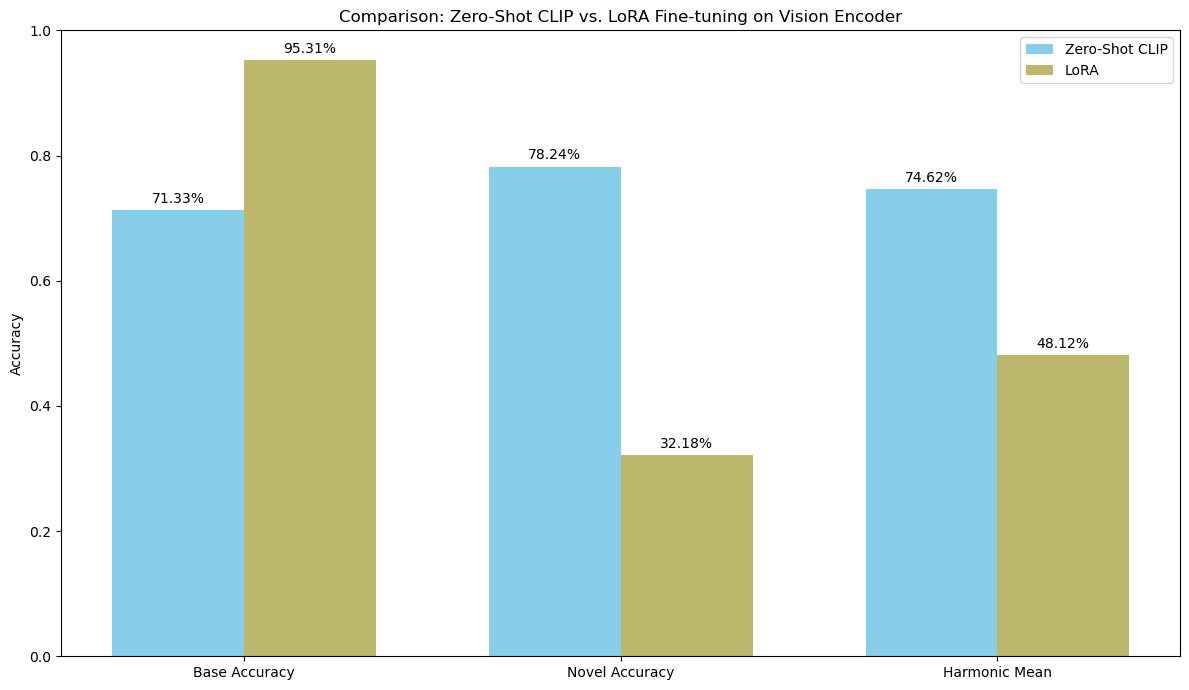

In [ ]:
# Plot comparison between Zero-Shot CLIP and LoRA-Vision
labels = ['Base Accuracy', 'Novel Accuracy', 'Harmonic Mean']
clip_scores = [base_accuracy_zeroshot, novel_accuracy_zeroshot, hm_zeroshot]
lora_scores = [base_accuracy_lora_vision, novel_accuracy_lora_vision, hm_lora_vision]

x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots(figsize=(12, 7))
rects1 = ax.bar(x - width/2, clip_scores, width, label='Zero-Shot CLIP', color='skyblue')
rects2 = ax.bar(x + width/2, lora_scores, width, label='LoRA', color='darkkhaki')

ax.set_ylabel('Accuracy')
ax.set_title('Comparison: Zero-Shot CLIP vs. LoRA Fine-tuning on Vision Encoder')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.0)
ax.legend()
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
plt.show()

Unfortunately, the initial fine-tuning results are strong on the base classes but show poor accuracy on the novel classes. This indicates that the model struggles to generalize beyond the base distribution, a phenomenon known as "Catastrophic Forgetting". To address this, we first attempted to implement an advanced strategy inspired by the paper "Fine Tuning without Catastrophic Forgetting via Selective Low Rank Adaptation" [5].

The core idea is to introduce a mechanism to selectively activate or deactivate LoRA modules. This is achieved by adding a learnable parameter, the lora_gate ($g_i$), for each LoRA module, which modulates its output:
$$
ΔW(x)=ΔW(x)⋅σ(g_{i})
$$
To encourage selectivity, a penalty is added to the main loss function, pushing non-essential gates towards zero:
$$
L_{total}=L_{original}+λ_{i}∑∣g_{i}∣
$$
Where $L_{original}$ is the standard cross-entropy loss and $λ$ is a coefficient that controls the strength of the penalty. 
During first attempts the penalty doesn't descrease during the training phase.
This led us to a more sophisticated hypothesis: the issue might not be the magnitude of the coefficient, but rather the timing of its application. At the beginning of the training, the model has no information about which LoRA modules are useful. Imposing a strong penalty from the start would force the model to deactivate all modules as the safest strategy.

We therefore decided to allow the model an initial "exploration" phase. In our final implementation, we started the training with $λ=0$ for the first few epochs, and then gradually increased its value up to a maximum of 1.5 in the subsequent epochs.

However, our experiments showed that this improvement was not sufficient to mitigate the problem in our specific context. To address this, we explore additional techniques aimed at preserving performance on novel classes while maintaining or improving accuracy on base classes. Specifically, we apply Tip-Adapter [4], followed by a logit ensembling strategy combined with LoRA-based adaptation.

### Tip-Adapter-F and Adaptive Ensemble

We build on a two-expert framework combining the strengths of the original CLIP model (the generalist) and a LoRA-finetuned CLIP model specialized for base classes (the specialist). This approach leverages Tip-Adapter-F, a cache-based method that enhances few-shot adaptation by storing and reusing features extracted from the training set, alongside an adaptive ensemble that dynamically weights predictions from both experts to optimize accuracy on both base and novel classes.

### Theory
The key idea behind Tip-Adapter-F is to construct a feature cache from the training images using the LoRA-finetuned model, which captures specialized representations for the base classes. At inference, the similarity between test image features and this cache is combined with zero-shot logits from the fine-tuned model to boost prediction confidence. This mechanism effectively integrates explicit memory of the training data into the model’s decision process, improving base-class performance without retraining.

To maintain generalization on unseen (novel) classes, the original CLIP model’s zero-shot predictions are preserved as a complementary generalist expert. The adaptive ensemble blends the specialist (Tip-Adapter-F-enhanced fine-tuned model) and the generalist (original CLIP) by weighting their softmax probabilities with a parameter β that reflects confidence: higher weight is given to the specialist on base classes and to the generalist on novel classes. This dynamic weighting balances specialization with generalization, addressing the common challenge of base-to-novel trade-offs.

### Implementation Details
#### Cache Creation:
We create the Tip-Adapter feature cache by extracting normalized image embeddings from the LoRA-finetuned model over the base training set, saving both features and labels. This cache acts as a memory bank representing specialized knowledge acquired during fine-tuning.

#### Adaptive Ensemble Evaluation:
During evaluation, both the original and LoRA-finetuned models encode text prompts for the target classes to generate normalized text features. For each test batch:

1. The original model produces zero-shot image features, from which logits and softmax probabilities over classes are computed.

2. The LoRA-finetuned model produces image features used for two predictions: zero-shot logits (similar to the original model) and cache-based logits derived from similarity between image features and the cached training features. These are combined with a scaling hyperparameter (tip_alpha) to form Tip-Adapter logits and probabilities.

3. If evaluating on base classes, the Tip-Adapter logits include cache information; for novel classes, the cache is ignored, relying solely on the fine-tuned model’s zero-shot predictions.

4. The ensemble probability distribution is then calculated by interpolating between the generalist and specialist probabilities using β (higher β on base classes, lower on novel classes).

5. Final predictions are made by selecting the class with the highest ensembled probability.

Accuracy is computed for both base and novel test sets, and their harmonic mean is reported to quantify balanced performance across known and unknown classes.

This method effectively leverages the LoRA fine-tuning for specialization while preserving CLIP’s original zero-shot generalization through adaptive ensemble weighting and cache-based memory augmentation.

In [23]:
print("Tip-Adapter-F and Adaptive Ensemble")
print("Combining Tip-Adapter-F with an Adaptive Ensemble on the LoRA fine-tuned model.")

# Create the cache for Tip-Adapter-F using the LoRA-fine-tuned model
@torch.no_grad()
def create_cache(model, train_loader, device):
    """Extracts features from the training set to create the Tip-Adapter cache."""
    model.eval()
    all_features = []
    all_labels = []
    print("Creating feature cache from train_base with LoRA model...")
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        features = model.encode_image(images)
        features /= features.norm(dim=-1, keepdim=True)
        all_features.append(features)
        all_labels.append(labels)
    return torch.cat(all_features), torch.cat(all_labels)


# We use the LoRA model as the "specialist" for cache creation
train_base_loader_no_shuffle = torch.utils.data.DataLoader(train_base,
                                                           batch_size=32,
                                                           shuffle=False)
cache_features, cache_labels = create_cache(lora_model,
                                            train_base_loader_no_shuffle,
                                            device)
print("Cache created.")

@torch.no_grad()
def eval_adaptive_tip_ensemble(original_model, finetuned_model, cache_feats, cache_labs, dataset, categories, batch_size, device, label=""):
    """Evaluates the adaptive ensemble using Tip-Adapter-F."""
    original_model.eval()
    finetuned_model.eval()
    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}
    cache_labs_remapped = torch.tensor([base_classes.index(l.item()) for l in cache_labs]).to(device)
    
    # Get text features for both models
    text_inputs = clip.tokenize([f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in categories]).to(device)
    original_text_features = original_model.encode_text(text_inputs)
    original_text_features /= original_text_features.norm(dim=-1, keepdim=True)
    
    finetuned_text_features = finetuned_model.encode_text(text_inputs)
    finetuned_text_features /= finetuned_text_features.norm(dim=-1, keepdim=True)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    correct_predictions = 0
    tip_alpha = 1.0  # Hyperparameter for Tip-Adapter
    
    for images, targets in tqdm(dataloader, desc=label):
        targets_remapped = torch.tensor([contig_cat2idx[t.item()] for t in targets]).to(device)
        images = images.to(device)

        # --- Prediction from Model 1: Original CLIP (Generalist Expert) ---
        original_image_features = original_model.encode_image(images)
        original_image_features /= original_image_features.norm(dim=-1, keepdim=True)
        original_logits = original_image_features @ original_text_features.T
        original_probs = F.softmax(original_model.logit_scale.exp() * original_logits, dim=-1)

        # --- Prediction from Model 2: Tip-Adapter-F (Specialist Expert) ---
        finetuned_image_features = finetuned_model.encode_image(images)
        finetuned_image_features /= finetuned_image_features.norm(dim=-1, keepdim=True)
        
        zeroshot_logits_finetuned = finetuned_model.logit_scale.exp() * (finetuned_image_features @ finetuned_text_features.T)
        
        # Tip-Adapter cache logits
        cache_similarity = finetuned_image_features @ cache_feats.T
        cache_logits = torch.zeros(images.shape[0], len(base_classes), dtype=cache_similarity.dtype, device=device)
        cache_logits.scatter_add_(1, cache_labs_remapped.repeat(images.shape[0], 1), cache_similarity)

        # Combine Tip-Adapter logits
        if set(categories) == set(base_classes):
             tip_adapter_logits = zeroshot_logits_finetuned + tip_alpha * cache_logits
        else: # For novel classes, cache is not relevant, use only zero-shot from fine-tuned model
             tip_adapter_logits = zeroshot_logits_finetuned
        
        tip_adapter_probs = F.softmax(tip_adapter_logits, dim=-1)

        # --- Adaptive Ensemble ---
        if set(categories) == set(base_classes):
            beta = 0.8 # Higher confidence in the specialist for base classes
        else:
            beta = 0.2 # Higher confidence in the generalist for novel classes
        
        ensembled_probs = (1 - beta) * original_probs + beta * tip_adapter_probs
        
        predicted_class = ensembled_probs.argmax(dim=-1)
        correct_predictions += (predicted_class == targets_remapped).sum().item()

    accuracy = correct_predictions / len(dataset)
    return accuracy

print("\nFinal evaluation with Tip-Adapter-F and Adaptive Ensemble...")
base_accuracy_final = eval_adaptive_tip_ensemble(original_clip_model, lora_model, cache_features, cache_labels, test_base, base_classes, 128, device, label="🚀 Final on Base")
novel_accuracy_final = eval_adaptive_tip_ensemble(original_clip_model, lora_model, cache_features, cache_labels, test_novel, novel_classes, 128, device, label="🚀 Final on Novel")

hm_final = harmonic_mean(base_accuracy_final, novel_accuracy_final)

print(f"\n✅ Final Base Accuracy: {base_accuracy_final*100:.2f}%")
print(f"✅ Final Novel Accuracy: {novel_accuracy_final*100:.2f}%")
print(f"✅ Final Harmonic Mean: {hm_final*100:.2f}%")



Tip-Adapter-F and Adaptive Ensemble
Combining Tip-Adapter-F with an Adaptive Ensemble on the LoRA fine-tuned model.
Creating feature cache from train_base with LoRA model...


100%|██████████| 16/16 [00:06<00:00,  2.52it/s]


Cache created.

Final evaluation with Tip-Adapter-F and Adaptive Ensemble...


🚀 Final on Novel: 100%|██████████| 29/29 [00:57<00:00,  1.97s/it]


✅ Final Base Accuracy: 96.00%
✅ Final Novel Accuracy: 77.64%
✅ Final Harmonic Mean: 85.85%


## Results
Here, we present a comparative plot of the results obtained from each method to see their performance differences.

## 5. Comparison of All Strategies


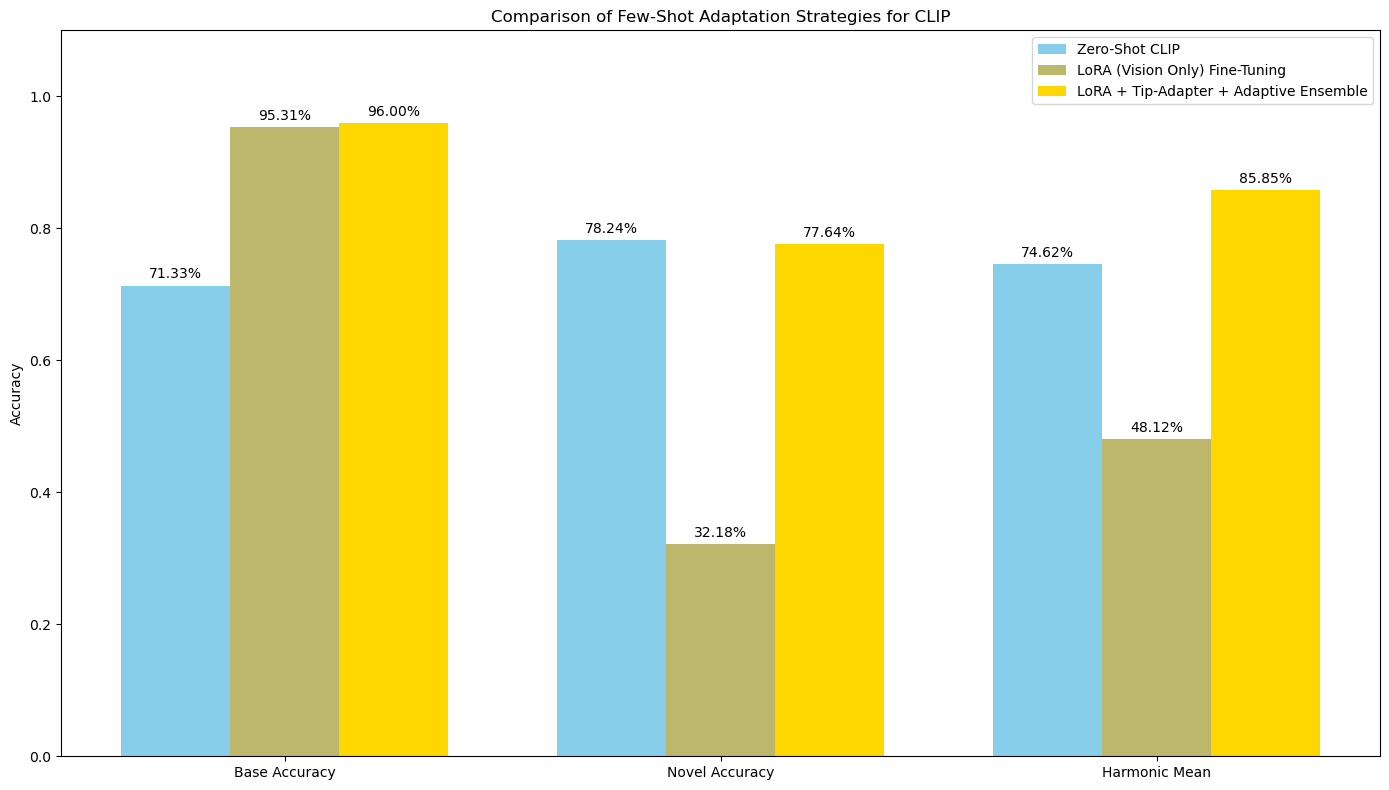

In [24]:
print("## 5. Comparison of All Strategies")

# Store final scores for comparison plot
lora_tip_ensemble_scores = [base_accuracy_final, novel_accuracy_final, hm_final]

# Prepare scores for plotting
labels = ['Base Accuracy', 'Novel Accuracy', 'Harmonic Mean']
zeroshot_scores = [base_accuracy_zeroshot, novel_accuracy_zeroshot, hm_zeroshot]
lora_text_scores = [base_accuracy_lora_vision, novel_accuracy_lora_vision, hm_lora_vision]
lora_tip_ensemble_scores = [base_accuracy_final, novel_accuracy_final, hm_final]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))

rects1 = ax.bar(x - width, zeroshot_scores, width, label='Zero-Shot CLIP', color='skyblue')
rects2 = ax.bar(x, lora_text_scores, width, label='LoRA (Vision Only) Fine-Tuning', color='darkkhaki')
rects3 = ax.bar(x + width, lora_tip_ensemble_scores, width, label='LoRA + Tip-Adapter + Adaptive Ensemble', color='gold')

ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Few-Shot Adaptation Strategies for CLIP')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.1)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height*100:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

### Discussion of the results


When LoRA was applied to the vision encoder the model became better aligned with the training distribution and achieved strong results on the base classes, although in our experiments it failed to preserve Novel accuracy. This suggests that LoRA modifies the image embedding space too aggressively. The main problem likely lies in the fact that LoRA focuses purely on weight adaptation and does not involve prompt optimization. In few-shot scenarios with very limited data, this often leads to overfitting on Base classes and a consequent loss of performance on Novel classes.

In contrast, Tip-Adapter-F exhibited a different behavior. By relying on cache-based similarity with few-shot exemplars, it was able to retain robust recognition of novel classes. Yet this method lacked the same representational flexibility as LoRA, and therefore did not reach comparable accuracy on the base categories. What emerged was a complementary relationship: LoRA specialized strongly on the classes it adapted to, while Tip-Adapter-F preserved the model’s capacity to generalize more broadly.

The ensemble strategy brought these two perspectives together. By combining logits from LoRA and Tip-Adapter-F, the ensemble produced higher scores on both base and novel categories, ultimately achieving the best harmonic mean. This suggests that the hybrid approach acted as a balancing mechanism, drawing on LoRA to refine semantic alignment while relying on Tip-Adapter-F to prevent the system from collapsing into overfitting. The results therefore underline the importance of designing adaptation strategies that do not only maximize performance on seen data but also safeguard the model’s zero-shot abilities.

## Conclusion

In this work, we examined parameter-efficient adaptation of CLIP for few-shot image classification on the Oxford Flowers102 dataset. Our experiments showed that applying LoRA to the vision encoder significantly increased accuracy on base categories but simultaneously reduced performance on novel ones, highlithing a strong overfitting and loss of generalization by the model. 

To balance this problem, we explored Tip-Adapter, which leverages a cache of few-shot exemplars to maintain performance on unseen categories. Although it does not reach LoRA’s level on base classes, its strength lies in preserving transferability. Finally, by combining LoRA and Tip-Adapter through logit ensembling, we obtained the most balanced results, achieving improved accuracy on both base and novel categories and thus the highest harmonic mean.

These findings suggest that no single parameter-efficient method fully resolves the trade-off between specialization and generalization. Instead, hybrid strategies that integrate complementary approaches provide a more effective path forward. Lots of future work are possible, such as investigate adaptive ensemble weights that adjust dynamically according to task difficulty or incorporate regularization mechanisms to mitigate overfitting in LoRA. Overall, our study underscores the value of combining lightweight adaptation with memory-based strategies to achieve efficient and robust few-shot learning in vision–language models.


## References

[1] M. -E. Nilsback and A. Zisserman, "Automated Flower Classification over a Large Number of Classes," 2008 Sixth Indian Conference on Computer Vision, Graphics & Image Processing, Bhubaneswar, India, 2008, pp. 722-729, doi: 10.1109/ICVGIP.2008.47.

[2] E. J. Hu, Y. Shen, P. Wallis, Z. Allen-Zhu, Y. Li, S. Wang, L. Wang, and W. Chen, "LoRA: Low-Rank Adaptation of Large Language Models"  2021.

[3] M. Zanella and I. Ben Ayed, "Low-Rank Few-Shot Adaptation of Vision-Language Models" 2022.

[4] R. Zhang, W. Zhang, R. Fang, P. Gao, K. Li, J. Dai, Y. Qiao, and H. Li, "Tip-Adapter: Training-free Adaptation of CLIP for Few-shot Classification" 2022.

[5] R. Akbarian Bafghi, C. Bagwell, A. Ravichandran, A. Shrivastava, and M. Raissi, "Fine Tuning without Catastrophic Forgetting via Selective Low Rank Adaptation" 2025.

[6] K. Zhou, J. Yang, C. C. Loy, and Z. Liu, “Learning to Prompt for Vision-Language Models” International Journal of Computer Vision (IJCV), 2022. 

[7] K. Zhou, J. Yang, C. C. Loy, and Z. Liu, “Conditional Prompt Learning for Vision-Language Models” Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), 2022. 

[8] P. Gao, S. Geng, R. Zhang, T. Ma, R. Fang, Y. Zhang, H. Li, and Y. Qiao, “CLIP-Adapter: Better Vision-Language Models with Feature Adapters” International Journal of Computer Vision (IJCV), 2024.

[9] H. Liu, D. Tam, M. Muqeeth, J. Mohta, T. Huang, M. Bansal, and C. Raffel, “Few-Shot Parameter-Efficient Fine-Tuning is Better and Cheaper than In-Context Learning” Advances in Neural Information Processing Systems (NeurIPS), 2022. 

[10] A. Radford, J. W. Kim, C. Hallacy, A. Ramesh, G. Goh, S. Agarwal, G. Sastry, A. Askell, P. Mishkin, J. Clark, et al., “Learning Transferable Visual Models from Natural Language Supervision” Proceedings of the International Conference on Machine Learning (ICML), 2021.